In [1]:
import os
import time

import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128
                                                    , shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(testset,batch_size=128
                                                     , shuffle=True, num_workers=4)


100%|██████████| 170498071/170498071 [00:02<00:00, 80209935.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
input_dim=trainset[0][0].shape[0]*trainset[0][0].shape[1]*trainset[0][0].shape[2]

In [4]:
all_train_labels = []
all_test_labels = []
all_val_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)



print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))




Training labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Training label distribution: tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

Test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Test label distribution: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


In [8]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate) :
        super(_DenseLayer,self).__init__()
        self.denselayers = nn.Sequential(
            OrderedDict(
                [   ("norm1", nn.BatchNorm2d(num_input_features)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("conv1", nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)),
                    ("norm2", nn.BatchNorm2d(bn_size * growth_rate)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("conv2", nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)),
                ]
            )
        )
        self.drop_rate=drop_rate


    def forward(self, input):
        concated_features = torch.cat(input, 1)
        new_features = self.denselayers(concated_features)
        new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):

    def __init__(self,num_layers,num_input_features,bn_size,growth_rate,drop_rate):
        super(_DenseBlock,self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.add_module("dl%d" % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition,self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet(nn.Module):

    def __init__(self,growth_rate= 32,block_config=[6, 12, 24, 16],num_init_features= 64,bn_size= 4,drop_rate = 0,num_classes = 1000):

        super(DenseNet,self).__init__()

        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            self.features.add_module("db%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module("norm5", nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        
        features = self.features(x)
        out = F.relu(features, inplace=True)
        
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        out = F.softmax(out,dim=1)
        return out
class AllConv (nn.Module):

    def __init__(self, n_classes):
        super(AllConv, self).__init__()
        
        self.n_classes = n_classes

        self.ipdrop = nn.Dropout (0.2)
        self.dropout = nn.Dropout (0.5)
        
        self.conv_1 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=96,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) 
    
        self.conv_2 = torch.nn.Conv2d(in_channels=96,
                                      out_channels=96,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)                             
        
        self.pool_1 = torch.nn.Conv2d(in_channels=96,
                                      out_channels=96,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)                  
                                    
        self.conv_3 = torch.nn.Conv2d(in_channels=96,
                                      out_channels=192,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)      
        
                                    
        self.conv_4 = torch.nn.Conv2d(in_channels=192,
                                      out_channels=self.n_classes,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)       
                                 
        self.pool_2 = torch.nn.Conv2d(in_channels=192,
                                      out_channels=192,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)      
                                    
        
        
    def forward(self, x):
        x = self.ipdrop (x)

        out = self.conv_1(x)
        out = F.relu(out)

        out = self.conv_2(out)
        out = F.relu(out)

        out = self.pool_1(out)
        out = F.relu(out)

        out = self.dropout (out)

        out = self.conv_3(out)
        out = F.relu(out)
        
        out = self.conv_4(out)
        out = F.relu(out)
        
        logits = F.adaptive_avg_pool2d(out, 1)
        # drop width
        logits.squeeze_(-1)
        # drop height
        logits.squeeze_(-1)
        preds = torch.softmax(logits, dim=1)
        return logits
class MLP(nn.Module):
    def __init__(self,n_classes=10,input_feat=768):
        super(MLP,self).__init__()
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("linear0", nn.Linear(input_feat,n_classes)),
                    ("relu0", nn.ReLU(inplace=True))
                    
                ]
            )
        )
    def forward(self,input):
        out = self.features(input)
        return out
class Gated_Network(nn.Module):
    def __init__(self,n_classes=10,input_dim=1024):
        super(Gated_Network,self).__init__()
        self.gamma = nn.Parameter(torch.ones(1))
        self.s = nn.Parameter(torch.zeros(3))
        self.dense = DenseNet(growth_rate=12,block_config=[6,12],num_classes=n_classes)
        self.mlp = MLP(n_classes=n_classes,input_feat=input_dim)
        self.all_conv = AllConv(n_classes=n_classes)
        self.input_dim=input_dim
    def forward(self,input):
        mlp=self.mlp(input.view(-1,self.input_dim))
        dense = self.dense(input)
        all_conv = self.all_conv(input)
        weights=F.softmax(self.s, dim=0).repeat(len(input),1,1).view(len(input),-1,1)
        stacked = torch.cat([mlp.view(mlp.shape[0],1,mlp.shape[1]), dense.view(dense.shape[0],1,dense.shape[1]),all_conv.view(all_conv.shape[0],1,all_conv.shape[1])], dim=1)
        sum=torch.sum(stacked*weights,dim=1)
        wighted_sum=self.gamma*sum
        return wighted_sum

In [9]:
def train_model(optimizer,trainloader,testloader,criterion,model,epochs):
    
    def train(optimizer,trainloader,criterion):
        model.train()
        train_loss=0
        y_true=[]
        y_pred=[]
        for images, labels in trainloader:
            model.zero_grad() 
            data = images.to(device)
            target = labels.to(device)
            output = model(data)
            loss = criterion(output,target)
            indices=torch.max(torch.exp(output),1)[1]
            train_loss+=loss.item()
            y_true+=list(target.detach().cpu().numpy())
            y_pred+=list(indices.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
        return train_loss/len(trainloader),accuracy_score(y_true,y_pred)
    def test(testloader,criterion):
        model.eval()
        y_true=[]
        y_pred=[]        
        val_loss = 0
        with torch.no_grad():
          for images, labels in testloader:
              data = images.to(device)
              target = labels.to(device)
              output = model(data)
              indices=torch.max(output,1)[1]
              y_true+=list(target.detach().cpu().numpy())
              y_pred+=list(indices.detach().cpu().numpy())
              val_loss += criterion(output, target).item()
        return val_loss/len(testloader),accuracy_score(y_true,y_pred)

        
    train_loss=[]
    test_loss=[]
    train_acc=[]
    test_acc=[]
    for epoch in tqdm(range(1, epochs + 1)):
        
        tr_loss,tr_acc=train(optimizer=optimizer,trainloader=trainloader,criterion=criterion)
        ts_loss,ts_acc=test(testloader,criterion=criterion)
        train_loss.append(tr_loss)
        test_loss.append(ts_loss)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
        print("train_acc",tr_acc)
        print("test_acc",ts_acc)
    return (train_loss,test_loss),(train_acc,test_acc)
    
def plot(Loss,EPOCH):
  x = list(range(1,EPOCH+1))
  fig, ax = plt.subplots(figsize=(7,7))
  ax.plot(x, Loss[0], '-', label='train', color='green')
  ax.plot(x, Loss[1], '-', label='test', color='red')
  ax.legend()
  plt.show()

In [10]:
gated_network=Gated_Network(n_classes=len(torch.unique(all_train_labels)),input_dim=input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH=50
criterion = nn.CrossEntropyLoss()
dense_net = gated_network.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(dense_net.parameters(), lr=0.001)
Loss,accuracy=train_model(optimizer,train_loader,test_loader,criterion,dense_net,EPOCH)


  2%|▏         | 1/50 [00:23<19:19, 23.66s/it]

train_acc 0.30862
test_acc 0.3439


  4%|▍         | 2/50 [00:47<18:51, 23.57s/it]

train_acc 0.42158
test_acc 0.4071


  6%|▌         | 3/50 [01:10<18:20, 23.41s/it]

train_acc 0.51094
test_acc 0.4765


  8%|▊         | 4/50 [01:34<18:01, 23.51s/it]

train_acc 0.57494
test_acc 0.5098


 10%|█         | 5/50 [01:56<17:28, 23.29s/it]

train_acc 0.6314
test_acc 0.5359


 12%|█▏        | 6/50 [02:20<17:07, 23.36s/it]

train_acc 0.66998
test_acc 0.6003


 14%|█▍        | 7/50 [02:43<16:46, 23.40s/it]

train_acc 0.69906
test_acc 0.6283


 16%|█▌        | 8/50 [03:07<16:23, 23.41s/it]

train_acc 0.7284
test_acc 0.6649


 18%|█▊        | 9/50 [03:30<16:01, 23.46s/it]

train_acc 0.74964
test_acc 0.6582


 20%|██        | 10/50 [03:54<15:38, 23.45s/it]

train_acc 0.76938
test_acc 0.6947


 22%|██▏       | 11/50 [04:17<15:07, 23.28s/it]

train_acc 0.78744
test_acc 0.7275


 24%|██▍       | 12/50 [04:40<14:45, 23.29s/it]

train_acc 0.80104
test_acc 0.7186


 26%|██▌       | 13/50 [05:03<14:22, 23.32s/it]

train_acc 0.81776
test_acc 0.7201


 28%|██▊       | 14/50 [05:27<14:00, 23.34s/it]

train_acc 0.82756
test_acc 0.7255


 30%|███       | 15/50 [05:51<13:41, 23.46s/it]

train_acc 0.84038
test_acc 0.7453


 32%|███▏      | 16/50 [06:14<13:17, 23.44s/it]

train_acc 0.85042
test_acc 0.7458


 34%|███▍      | 17/50 [06:37<12:49, 23.33s/it]

train_acc 0.85984
test_acc 0.7295


 36%|███▌      | 18/50 [07:00<12:27, 23.35s/it]

train_acc 0.8699
test_acc 0.7218


 38%|███▊      | 19/50 [07:24<12:05, 23.40s/it]

train_acc 0.87858
test_acc 0.7589


 40%|████      | 20/50 [07:47<11:41, 23.40s/it]

train_acc 0.88638
test_acc 0.7538


 42%|████▏     | 21/50 [08:11<11:22, 23.52s/it]

train_acc 0.89462
test_acc 0.722


 44%|████▍     | 22/50 [08:34<10:52, 23.32s/it]

train_acc 0.90242
test_acc 0.7532


 46%|████▌     | 23/50 [08:57<10:28, 23.28s/it]

train_acc 0.90714
test_acc 0.7611


 48%|████▊     | 24/50 [09:20<10:04, 23.25s/it]

train_acc 0.91164
test_acc 0.7691


 50%|█████     | 25/50 [09:44<09:41, 23.27s/it]

train_acc 0.91806
test_acc 0.7534


 52%|█████▏    | 26/50 [10:07<09:19, 23.29s/it]

train_acc 0.9241
test_acc 0.7431


 54%|█████▍    | 27/50 [10:30<08:54, 23.25s/it]

train_acc 0.9288
test_acc 0.753


 56%|█████▌    | 28/50 [10:53<08:29, 23.16s/it]

train_acc 0.93132
test_acc 0.7517


 58%|█████▊    | 29/50 [11:16<08:07, 23.20s/it]

train_acc 0.93282
test_acc 0.746


 60%|██████    | 30/50 [11:40<07:44, 23.22s/it]

train_acc 0.9391
test_acc 0.7656


 62%|██████▏   | 31/50 [12:03<07:20, 23.19s/it]

train_acc 0.94174
test_acc 0.7294


 64%|██████▍   | 32/50 [12:26<06:57, 23.22s/it]

train_acc 0.94514
test_acc 0.7585


 66%|██████▌   | 33/50 [12:49<06:32, 23.09s/it]

train_acc 0.94726
test_acc 0.7591


 68%|██████▊   | 34/50 [13:12<06:09, 23.09s/it]

train_acc 0.94954
test_acc 0.7461


 70%|███████   | 35/50 [13:35<05:47, 23.15s/it]

train_acc 0.95148
test_acc 0.7644


 72%|███████▏  | 36/50 [13:59<05:24, 23.18s/it]

train_acc 0.95508
test_acc 0.7614


 74%|███████▍  | 37/50 [14:22<05:02, 23.23s/it]

train_acc 0.95246
test_acc 0.7442


 76%|███████▌  | 38/50 [14:44<04:36, 23.00s/it]

train_acc 0.96004
test_acc 0.7665


 78%|███████▊  | 39/50 [15:08<04:13, 23.04s/it]

train_acc 0.95782
test_acc 0.7528


 80%|████████  | 40/50 [15:31<03:51, 23.11s/it]

train_acc 0.96122
test_acc 0.7661


 82%|████████▏ | 41/50 [15:54<03:27, 23.09s/it]

train_acc 0.96314
test_acc 0.7436


 84%|████████▍ | 42/50 [16:17<03:05, 23.19s/it]

train_acc 0.96324
test_acc 0.7575


 86%|████████▌ | 43/50 [16:40<02:41, 23.00s/it]

train_acc 0.96518
test_acc 0.7596


 88%|████████▊ | 44/50 [17:03<02:18, 23.02s/it]

train_acc 0.96344
test_acc 0.7523


 90%|█████████ | 45/50 [17:26<01:55, 23.08s/it]

train_acc 0.96458
test_acc 0.7677


 92%|█████████▏| 46/50 [17:49<01:32, 23.15s/it]

train_acc 0.9673
test_acc 0.7717


 94%|█████████▍| 47/50 [18:13<01:09, 23.16s/it]

train_acc 0.97126
test_acc 0.7685


 96%|█████████▌| 48/50 [18:36<00:46, 23.13s/it]

train_acc 0.9677
test_acc 0.7667


 98%|█████████▊| 49/50 [18:58<00:23, 23.01s/it]

train_acc 0.9675
test_acc 0.7624


100%|██████████| 50/50 [19:22<00:00, 23.24s/it]

train_acc 0.97134
test_acc 0.7534


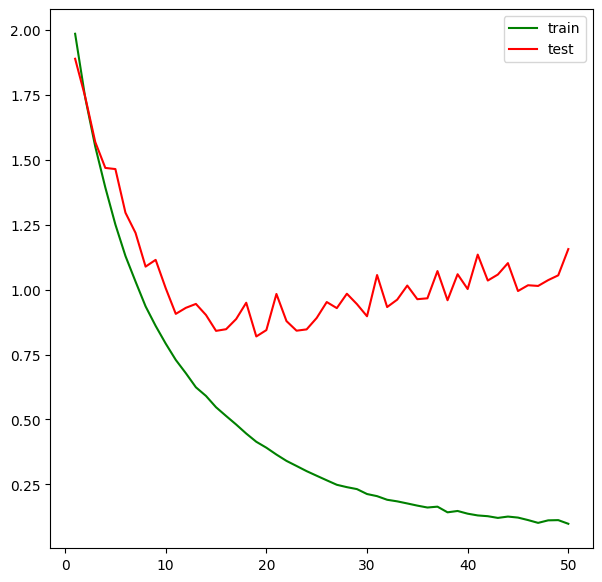

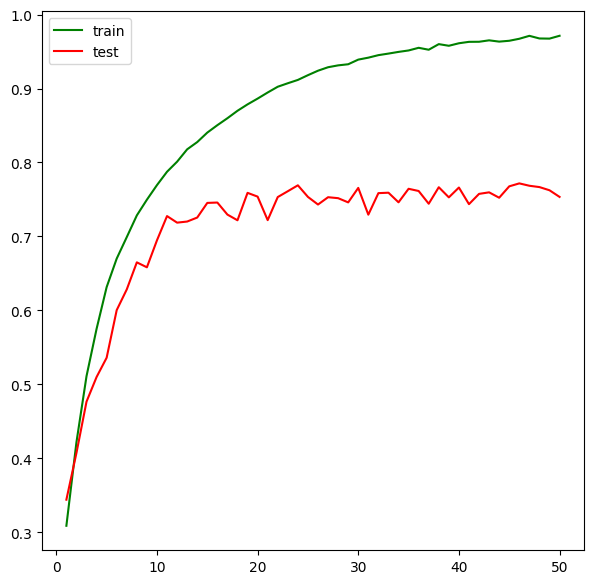

In [11]:
plot(Loss,EPOCH)
plot(accuracy,EPOCH)

In [12]:
torch.save(gated_network,"novel_cifar_10.pt")